1. Daten einlesen und Überprüfung der Struktur

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# 1. Daten einlesen
global_temp = pd.read_csv("GlobalLandTemperaturesByCountry/GlobalLandTemperaturesByCountry.csv")
holidays = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv")
oil = pd.read_csv("store-sales-time-series-forecasting/oil.csv")
stores = pd.read_csv("store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("store-sales-time-series-forecasting/transactions.csv")
walmart_sales = pd.read_csv("Walmart_Sales_Forecasting/clean_data.csv")

# Überprüfung der Datenstruktur
print(global_temp.head())
print(holidays.head())
print(oil.head())
print(stores.head())
print(transactions.head())
print(walmart_sales.head())

           dt  AverageTemperature  AverageTemperatureUncertainty Country
0  1743-11-01               4.384                          2.294   Åland
1  1743-12-01                 NaN                            NaN   Åland
2  1744-01-01                 NaN                            NaN   Åland
3  1744-02-01                 NaN                            NaN   Åland
4  1744-03-01                 NaN                            NaN   Åland
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4 

2. Daten bereinigen und verarbeiten

In [11]:
# Sicherstellen, dass der Projekt-Ordner existiert
project_folder = "01_Ablage"
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

# Pfad für die Textdatei zum Speichern der Print-Ausgaben
log_file = os.path.join(project_folder, "Datenanalyse_Log.txt")

# Funktion zum Speichern der Ausgaben in die Datei
def save_to_log(text):
    with open(log_file, 'a') as f:
        f.write(text + '\n')

# Gibt es fehlende Werte?
# Überprüfung auf fehlende Werte in den verschiedenen Dateien
save_to_log("Fehlende Werte in global_temp:")
save_to_log(str(global_temp.isnull().sum()))

save_to_log("Fehlende Werte in holidays_events:")
save_to_log(str(holidays.isnull().sum()))

save_to_log("Fehlende Werte in oil:")
save_to_log(str(oil.isnull().sum()))

save_to_log("Fehlende Werte in stores:")
save_to_log(str(stores.isnull().sum()))

save_to_log("Fehlende Werte in transactions:")
save_to_log(str(transactions.isnull().sum()))

save_to_log("Fehlende Werte in walmart_sales:")
save_to_log(str(walmart_sales.isnull().sum()))

# Entfernen oder Auffüllen?
# Entfernen
global_temp = global_temp.dropna(subset=['AverageTemperature'])

# Auffüllen
transactions = transactions.fillna(0)
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()
walmart_sales = walmart_sales.fillna(0)

# Datums- und Ortsinformationen korrekt formatieren
# Global Land Temperatures
global_temp['dt'] = pd.to_datetime(global_temp['dt'])

# Transactions
transactions['date'] = pd.to_datetime(transactions['date'])

# Ölpreise
oil['date'] = pd.to_datetime(oil['date'])

# Walmart Sales
walmart_sales['Date'] = pd.to_datetime(walmart_sales['Date'])

# Überprüfen, ob das Datumsformat korrekt übernommen wurde
save_to_log("Erste Datumswerte in global_temp:")
save_to_log(str(global_temp['dt'].head()))

save_to_log("Erste Datumswerte in transactions:")
save_to_log(str(transactions['date'].head()))

save_to_log("Erste Datumswerte in oil:")
save_to_log(str(oil['date'].head()))

save_to_log("Erste Datumswerte in walmart_sales:")
save_to_log(str(walmart_sales['Date'].head()))

# Verarbeitung von Feiertagsdaten
# Falls es ein Datumsfeld in holidays_events gibt, konvertiere es in ein Datetime-Format
holidays['date'] = pd.to_datetime(holidays['date'])

# Hinweis: Die Visualisierungen kannst du ebenfalls speichern, indem du folgendes für Plots hinzufügst:
# Beispiel: Speichern einer Visualisierung
# plt.savefig(os.path.join(project_folder, "plotname.png"))


3. Explorative Analyse (EDA) und deren Visualisierungen + Korrelationen

In [12]:
# Beschreibende Analysen
save_to_log("Global Land Temperatures - Beschreibende Statistik:")
save_to_log(str(global_temp.describe()))

save_to_log("Transactions (Store Sales) - Beschreibende Statistik:")
save_to_log(str(transactions.describe()))

save_to_log("Oil Prices - Beschreibende Statistik:")
save_to_log(str(oil.describe()))

save_to_log("Walmart Sales - Beschreibende Statistik:")
save_to_log(str(walmart_sales.describe()))

# Visualisierungen

# Zeitreihen-Darstellung von Temperatur und Verkaufszahlen
# Plot für Temperaturen
plt.figure(figsize=(10, 5))
sns.lineplot(data=global_temp, x='dt', y='AverageTemperature', label='Temperatur')
plt.title('Temperatur über die Zeit')
plt.xlabel('Datum')
plt.ylabel('Durchschnittstemperatur')
# Speichern des Plots
plt.savefig(os.path.join(project_folder, "Temperatur_ueber_Zeit.png"))
plt.close()  # Schließt den Plot, damit er nicht im Speicher bleibt

# Plot für Verkäufe (Store Sales)
plt.figure(figsize=(10, 5))
sns.lineplot(data=transactions, x='date', y='transactions', label='Verkäufe')
plt.title('Verkäufe über die Zeit (Transactions)')
plt.xlabel('Datum')
plt.ylabel('Anzahl der Verkäufe')
# Speichern des Plots
plt.savefig(os.path.join(project_folder, "Verkaeufe_ueber_Zeit.png"))
plt.close()

# Plot für Walmart Verkäufe
plt.figure(figsize=(10, 5))
sns.lineplot(data=walmart_sales, x='Date', y='Weekly_Sales', label='Walmart Verkäufe')
plt.title('Walmart Verkäufe über die Zeit')
plt.xlabel('Datum')
plt.ylabel('Wöchentliche Verkäufe')
# Speichern des Plots
plt.savefig(os.path.join(project_folder, "Walmart_Verkaeufe_ueber_Zeit.png"))
plt.close()

# Korrelationen untersuchen

# Korrelationen für Transaktionen
corr_transactions = transactions.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_transactions, annot=True, cmap="coolwarm")
plt.title('Korrelationen der Transaktionsdaten')
# Speichern des Heatmaps
plt.savefig(os.path.join(project_folder, "Korrelationen_Transaktionsdaten.png"))
plt.close()

# Korrelationen für Walmart

# Einzigartige Werte der Spalte 'Type' auslesen
unique_types = walmart_sales['Type'].unique()
save_to_log("Einzigartige Werte in der Spalte 'Type': " + str(unique_types))

# Zuordnung der 'Type'-Werte zu numerischen Werten
type_mapping = {
    'A': 1,
    'B': 2,
    'C': 3
}

# Die Spalte 'Type' mit den numerischen Werten ersetzen
walmart_sales['Type'] = walmart_sales['Type'].map(type_mapping)

# Überprüfen, ob die Umwandlung erfolgreich war
save_to_log("Erste fünf Zeilen der Spalte 'Type' nach Umwandlung:")
save_to_log(str(walmart_sales['Type'].head()))

# Korrelationen für Walmart Verkaufsdaten
corr_walmart = walmart_sales.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_walmart, annot=True, cmap="coolwarm")
plt.title('Korrelationen der Walmart Verkaufsdaten')
# Speichern des Heatmaps
plt.savefig(os.path.join(project_folder, "Korrelationen_Walmart_Verkaeufe.png"))
plt.close()


4. Daten kombinieren

In [13]:
# Verknüpfen der Temperaturdaten mit den Transaktionsdaten anhand des Datums
combined_transactions = pd.merge(transactions, global_temp, left_on='date', right_on='dt', how='inner')

# Nur Daten für die USA herausfiltern
combined_transactions = combined_transactions[combined_transactions['Country'] == 'United States']

# Überprüfen, ob die Verknüpfung erfolgreich war
save_to_log("Kombinierte Transaktionsdaten mit Temperaturdaten (USA):")
save_to_log(str(combined_transactions.head()))

# Verknüpfen der Temperaturdaten mit Walmart Sales anhand des Datums
combined_walmart = pd.merge(walmart_sales, global_temp, left_on='Date', right_on='dt', how='inner')

# Nur Daten für die USA herausfiltern
combined_walmart = combined_walmart[combined_walmart['Country'] == 'United States']

# Überprüfen, ob die Verknüpfung erfolgreich war
save_to_log("Kombinierte Walmart-Verkäufe mit Temperaturdaten (USA):")
save_to_log(str(combined_walmart.head()))

# Unnötige Spalten wie doppelte Datumsangaben entfernen
combined_transactions.drop(columns=['dt', 'Country'], inplace=True)
combined_walmart.drop(columns=['dt', 'Country'], inplace=True)

# Visualisierung speichern
def save_plot(fig, filename):
    filepath = os.path.join(project_folder, filename)
    fig.savefig(filepath)
    save_to_log(f"Visualisierung gespeichert unter: {filepath}")


5. Analyse des Einflusses von Wetter auf die Preise

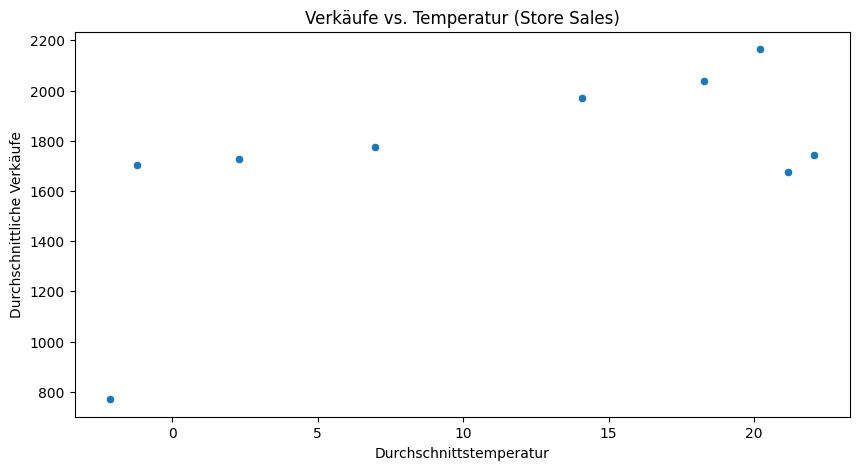

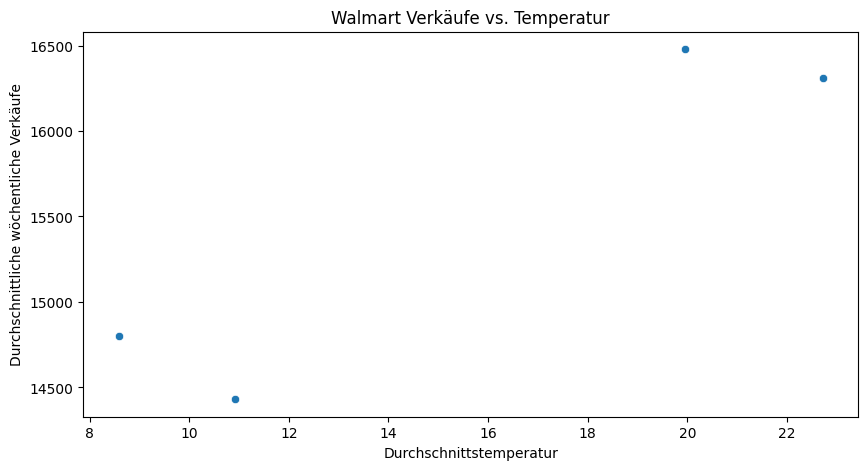

In [15]:
# Funktion zum Speichern von Prints ins Log
def save_to_log(text):
    with open(log_file, "a") as log:
        log.write(text + "\n")

# Funktion zum Speichern von Visualisierungen
def save_plot(fig, filename):
    filepath = os.path.join(project_folder, filename)
    fig.savefig(filepath)
    save_to_log(f"Visualisierung gespeichert unter: {filepath}")

# Erstellung einer neuen Spalte für Jahr und Monat
combined_transactions['year_month'] = combined_transactions['date'].dt.to_period('M')

# Berechnen der monatlichen Durchschnittswerte für Verkäufe und Temperatur
monthly_data_transactions = combined_transactions.groupby('year_month').agg({
    'transactions': 'mean',
    'AverageTemperature': 'mean'
}).reset_index()

# Überprüfen auf nicht-numerische Werte
save_to_log("Datentypen von monatlichen Transaktionen und Temperaturen:")
save_to_log(str(monthly_data_transactions[['transactions', 'AverageTemperature']].dtypes))
save_to_log(str(monthly_data_transactions[['transactions', 'AverageTemperature']].head()))

# Suche nach nicht-numerischen Werten
invalid_transactions = monthly_data_transactions[~monthly_data_transactions['transactions'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
invalid_temperatures = monthly_data_transactions[~monthly_data_transactions['AverageTemperature'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

save_to_log("Nicht-numerische Transaktionen:")
save_to_log(str(invalid_transactions))
save_to_log("Nicht-numerische Temperaturen:")
save_to_log(str(invalid_temperatures))

# Konvertiere die Spalten in numerische Werte
monthly_data_transactions['transactions'] = pd.to_numeric(monthly_data_transactions['transactions'], errors='coerce')
monthly_data_transactions['AverageTemperature'] = pd.to_numeric(monthly_data_transactions['AverageTemperature'], errors='coerce')

# Überprüfen auf NaN-Werte nach der Konvertierung
save_to_log("NaN-Werte nach der Konvertierung:")
save_to_log(str(monthly_data_transactions.isnull().sum()))

# Entferne Zeilen mit NaN-Werten
monthly_data_transactions.dropna(subset=['transactions', 'AverageTemperature'], inplace=True)

# Scatter Plot zwischen Temperatur und Verkäufen
plt.figure(figsize=(10, 5))
sns.scatterplot(data=monthly_data_transactions, x='AverageTemperature', y='transactions')
plt.title('Verkäufe vs. Temperatur (Store Sales)')
plt.xlabel('Durchschnittstemperatur')
plt.ylabel('Durchschnittliche Verkäufe')
fig1 = plt.gcf()  # Figure-Handle für das Speichern erhalten
save_plot(fig1, 'Verkaeufe_vs_Temperatur_Store_Sales.png')
plt.show()

# Lineare Regression (Einfluss der Temperatur auf die Verkäufe)
X_transactions = monthly_data_transactions[['AverageTemperature']]
y_transactions = monthly_data_transactions['transactions']

model_transactions = LinearRegression()
model_transactions.fit(X_transactions, y_transactions)

save_to_log("Steigung (Einfluss der Temperatur auf Verkäufe):" + str(model_transactions.coef_))
save_to_log("Intercept: " + str(model_transactions.intercept_))

# Erstellung einer neuen Spalte für Jahr und Monat in den Walmart-Daten
combined_walmart['year_month'] = combined_walmart['Date'].dt.to_period('M')

# Berechnen der monatlichen Durchschnittswerte für Verkäufe und Temperatur
monthly_data_walmart = combined_walmart.groupby('year_month').agg({
    'Weekly_Sales': 'mean',
    'AverageTemperature': 'mean'
}).reset_index()

# Überprüfen auf nicht-numerische Werte
save_to_log("Datentypen von monatlichen Walmart-Verkäufen und Temperaturen:")
save_to_log(str(monthly_data_walmart[['Weekly_Sales', 'AverageTemperature']].dtypes))
save_to_log(str(monthly_data_walmart[['Weekly_Sales', 'AverageTemperature']].head()))

# Suche nach nicht-numerischen Werten
invalid_walmart_sales = monthly_data_walmart[~monthly_data_walmart['Weekly_Sales'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
invalid_walmart_temperatures = monthly_data_walmart[~monthly_data_walmart['AverageTemperature'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

save_to_log("Nicht-numerische Walmart-Verkäufe:")
save_to_log(str(invalid_walmart_sales))
save_to_log("Nicht-numerische Temperaturen:")
save_to_log(str(invalid_walmart_temperatures))

# Konvertiere die Spalten in numerische Werte
monthly_data_walmart['Weekly_Sales'] = pd.to_numeric(monthly_data_walmart['Weekly_Sales'], errors='coerce')
monthly_data_walmart['AverageTemperature'] = pd.to_numeric(monthly_data_walmart['AverageTemperature'], errors='coerce')

# Überprüfen auf NaN-Werte nach der Konvertierung
save_to_log("NaN-Werte nach der Konvertierung in Walmart-Daten:")
save_to_log(str(monthly_data_walmart.isnull().sum()))

# Entferne Zeilen mit NaN-Werten
monthly_data_walmart.dropna(subset=['Weekly_Sales', 'AverageTemperature'], inplace=True)

# Scatter Plot zwischen Temperatur und Walmart Verkäufen
plt.figure(figsize=(10, 5))
sns.scatterplot(data=monthly_data_walmart, x='AverageTemperature', y='Weekly_Sales')
plt.title('Walmart Verkäufe vs. Temperatur')
plt.xlabel('Durchschnittstemperatur')
plt.ylabel('Durchschnittliche wöchentliche Verkäufe')
fig2 = plt.gcf()  # Figure-Handle für das Speichern erhalten
save_plot(fig2, 'Walmart_Verkaeufe_vs_Temperatur.png')
plt.show()

# Lineare Regression (Einfluss der Temperatur auf Walmart Verkäufe)
X_walmart = monthly_data_walmart[['AverageTemperature']]
y_walmart = monthly_data_walmart['Weekly_Sales']

model_walmart = LinearRegression()
model_walmart.fit(X_walmart, y_walmart)

save_to_log("Steigung (Einfluss der Temperatur auf Walmart Verkäufe): " + str(model_walmart.coef_))
save_to_log("Intercept: " + str(model_walmart.intercept_))

6. Random-Forest und andere

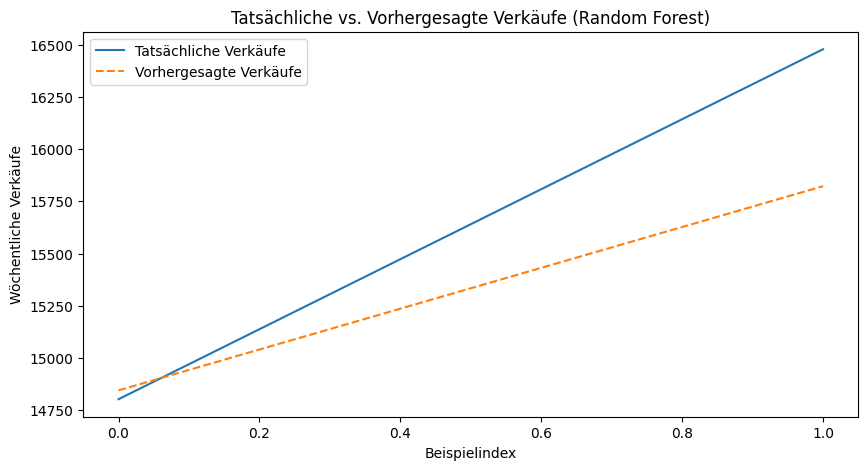

In [17]:
# Walmart
# Erstellung des Features und des Zielwerts
X_walmart = monthly_data_walmart[['AverageTemperature']]
y_walmart = monthly_data_walmart['Weekly_Sales']

# Aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_walmart, y_walmart, test_size=0.45, random_state=9)  # Default-Werte: test_size=0.2, random_state=42

# Modell erstellen
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Modell trainieren
rf_model.fit(X_train, y_train)

# Vorhersagen für die Testdaten machen
y_pred = rf_model.predict(X_test)

# Ergebnisse anzeigen und ins Log speichern
save_to_log("Vorhersagen: " + str(y_pred))

# Modellperformance überprüfen
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

save_to_log(f"Mean Squared Error: {mse}")
save_to_log(f"R^2 Score: {r2}")

# Forecasting (Walmart)
# Beispiel: Vorhersagen für zukünftige Temperaturen
future_temperatures = pd.DataFrame({'AverageTemperature': [30, 35, 40, 45]})  # Beispielhafte zukünftige Temperaturen

# Vorhersagen für die zukünftigen Temperaturen
future_sales_predictions = rf_model.predict(future_temperatures)

save_to_log("Vorhergesagte Verkäufe für zukünftige Temperaturen: " + str(future_sales_predictions))

# Visualisierung des Forecast
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Tatsächliche Verkäufe')
plt.plot(y_pred, label='Vorhergesagte Verkäufe', linestyle='--')
plt.title('Tatsächliche vs. Vorhergesagte Verkäufe (Random Forest)')
plt.xlabel('Beispielindex')
plt.ylabel('Wöchentliche Verkäufe')
plt.legend()
fig3 = plt.gcf()  # Figure-Handle für das Speichern erhalten
save_plot(fig3, 'Tatsächliche_vs_Vorhergesagte_Verkaeufe_Random_Forest.png')
plt.show()